The EDA phase was done in the last step. In this notebook, we will develop Random forest, xgboost, catboost models for 3 months lag of defualt flag.

All project 's information and datasets can be found on the following page:
https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction

In [1]:
# Load a auto time for the entire notebook
%load_ext autotime

time: 0 ns (started: 2022-12-18 18:15:03 -06:00)


In [2]:
# Load required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Usefull package for progress monitoring in for loops and\or 
from tqdm import tqdm
tqdm.pandas()

time: 2.11 s (started: 2022-12-18 18:15:03 -06:00)


In [3]:
# Reload the Cleaned Data
alldata= pd.read_csv(r'C:\Users\shaha\OneDrive\Documents\credit_score\Final_Data.csv', index_col=0)
alldata.shape

(687454, 63)

time: 1.98 s (started: 2022-12-18 18:15:05 -06:00)


In [4]:
alldata

,MONTHS_BALANCE,CNT_CHILDREN,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,FLAG_EMPLOYED,MONTH_EMPLOYED,AMT_INCOME_TOTAL_BUKET,...,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,STATUS,COUNT,Modified_STATUS,rolling_average,BINARY_STATUS,3M_LABEL
ID,,,,,,,,,,,,,,,,,,,,,
5008804,0,0,1,1,0,0,2.0,True,152.0,8,...,0,0,1,0,C,16,0,0.000000,0,NaN
5008804,-1,0,1,1,0,0,2.0,True,152.0,8,...,0,0,1,0,C,16,0,0.000000,0,NaN
5008804,-2,0,1,1,0,0,2.0,True,152.0,8,...,0,0,1,0,C,16,0,0.000000,0,NaN
5008804,-3,0,1,1,0,0,2.0,True,152.0,8,...,0,0,1,0,C,16,0,0.000000,0,0.0
5008804,-4,0,1,1,0,0,2.0,True,152.0,8,...,0,0,1,0,C,16,0,0.000000,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5150337,-9,0,1,0,0,0,1.0,True,40.0,2,...,0,0,1,0,0,14,0,0.000000,0,0.0
5150337,-10,0,1,0,0,0,1.0,True,40.0,2,...,0,0,1,0,2,14,2,0.666667,1,0.0
5150337,-11,0,1,0,0,0,1.0,True,40.0,2,...,0,0,1,0,1,14,1,1.000000,1,0.0


time: 250 ms (started: 2022-12-18 18:15:07 -06:00)


# Develop Predictive Model based on 3 month History

### Handeling the inbalanced data

In [5]:
# Removing the rows that have null value  in 3 month lag. 
data= alldata.dropna(subset = ['3M_LABEL']).reset_index(drop=True)
print(data.shape)

(617197, 63)
time: 281 ms (started: 2022-12-18 18:15:08 -06:00)


0.0    608053
1.0      9144
Name: 3M_LABEL, dtype: int64

0.0    0.985185
1.0    0.014815
Name: 3M_LABEL, dtype: float64

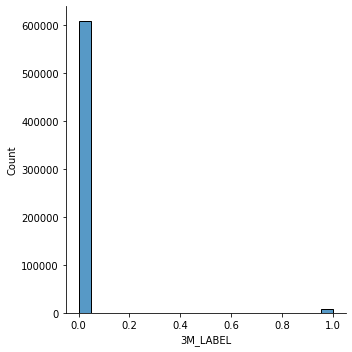

time: 531 ms (started: 2022-12-18 18:15:08 -06:00)


In [6]:
# Check the balance\imbalance of label

# thest the balance/imbalace label
display(data['3M_LABEL'].value_counts(normalize=False),data['3M_LABEL'].value_counts(normalize=True))


plt.rcParams["figure.figsize"] = [6,4]
sns.displot(data['3M_LABEL'], kde = False)
plt.show();

0.0    18288
1.0     9144
Name: 3M_LABEL, dtype: int64

0.0    0.666667
1.0    0.333333
Name: 3M_LABEL, dtype: float64

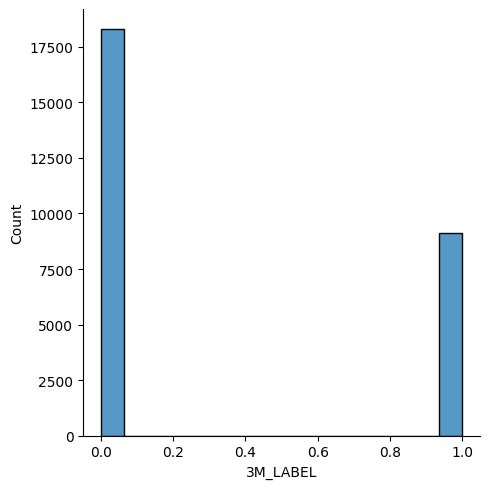

time: 500 ms (started: 2022-12-18 18:15:08 -06:00)


In [7]:
# Under-sampling Techniques to Handle Imbalanced Data
data_0 = data.loc[data['3M_LABEL']==0,:].sample(2*len(data.loc[data['3M_LABEL']==1,:]))
data_1 = data.loc[data['3M_LABEL']==1,:]
data = pd.concat([data_0,data_1] ).sample(frac = 1).sample(frac = 1).sample(frac = 1).reset_index(drop = True)

display(data['3M_LABEL'].value_counts(normalize=False),data['3M_LABEL'].value_counts(normalize=True))

sns.displot(data['3M_LABEL'], kde = False)
plt.show();

In [8]:
# Labels are the values we want to predict
# Remove the labels from the features. axis 1 refers to the columns
y = data.loc[:,'3M_LABEL'].astype(float) #or"float64"


x = data.iloc[:,1:]                                                     # We do not need the "ID"
x = data.drop(['3M_LABEL','BINARY_STATUS','STATUS'], axis = 1)     # 'COUNT',    /
# Saving feature names for later use
feature_list = list(x.columns)
# should be carefull for float values. we need decimals if we have.


time: 16 ms (started: 2022-12-18 18:15:09 -06:00)


In [9]:
y.value_counts(dropna = False)

0.0    18288
1.0     9144
Name: 3M_LABEL, dtype: int64

time: 15 ms (started: 2022-12-18 18:15:09 -06:00)


In [10]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.35, random_state = 42)   # Should i go for stratify = lable? NO! https://www.scribbr.com/methodology/stratified-sampling/

time: 156 ms (started: 2022-12-18 18:15:09 -06:00)


In [11]:
y_test.value_counts()

0.0    6393
1.0    3209
Name: 3M_LABEL, dtype: int64

time: 0 ns (started: 2022-12-18 18:15:09 -06:00)


In [12]:
print('Training Features Shape:', x_train.shape)
print('Training Labels Shape:', y_train.shape)   #no value because it is a 
print('Testing Features Shape:', x_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (17830, 60)
Training Labels Shape: (17830,)
Testing Features Shape: (9602, 60)
Testing Labels Shape: (9602,)
time: 0 ns (started: 2022-12-18 18:15:09 -06:00)


### Model #1 for 3 month Lag: Random Forest 

In [13]:
# 1) Develop a preliminary Random Forest Model

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score ,roc_auc_score , f1_score        
rf_model = RandomForestClassifier(n_estimators = 10, random_state = 42, verbose=0) 
rf_model.fit(x_train, y_train)
y_pred_prob = rf_model.predict_proba(x_test)
y_predict = rf_model.predict(x_test)
print('accuracy_score:' , accuracy_score(y_test, y_predict))
print('precision_score:', precision_score(y_test, y_predict))
print('recall_score:'   , recall_score(y_test, y_predict))
print('roc_auc_score:'  , roc_auc_score(y_test, y_predict))
print('f1_score:', f1_score(y_test, y_predict))

accuracy_score: 0.8715892522391169
precision_score: 0.8750949126803341
recall_score: 0.7182923028980991
roc_auc_score: 0.8334148828740456
f1_score: 0.7889782645901079
time: 375 ms (started: 2022-12-18 18:15:09 -06:00)


In [14]:
# Manual ROC curve
y_pred_prob = rf_model.predict_proba(x_test)[:,1]
df_test = pd.DataFrame({"predicted":y_pred_prob})
df_test['actual'] = y_test.values
# df.to_csv(r'C:\Users\shaha\OneDrive\Documents\credit_score\test.csv')

time: 32 ms (started: 2022-12-18 18:15:10 -06:00)


In [15]:
df_test['actual'].value_counts()

0.0    6393
1.0    3209
Name: actual, dtype: int64

time: 0 ns (started: 2022-12-18 18:15:10 -06:00)


100%|██████████| 101/101 [00:00<00:00, 637.25it/s]


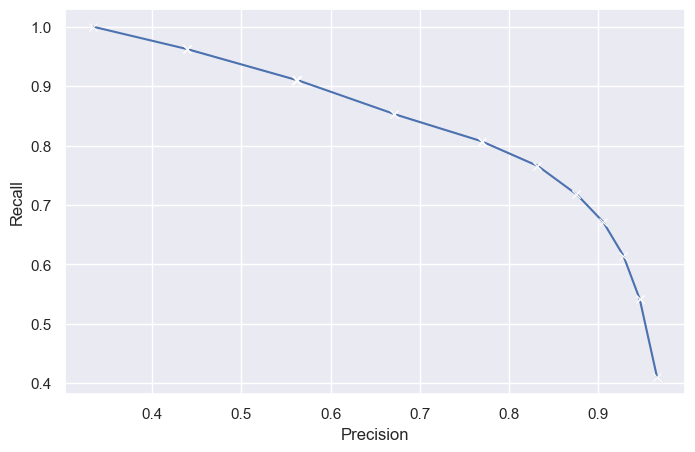

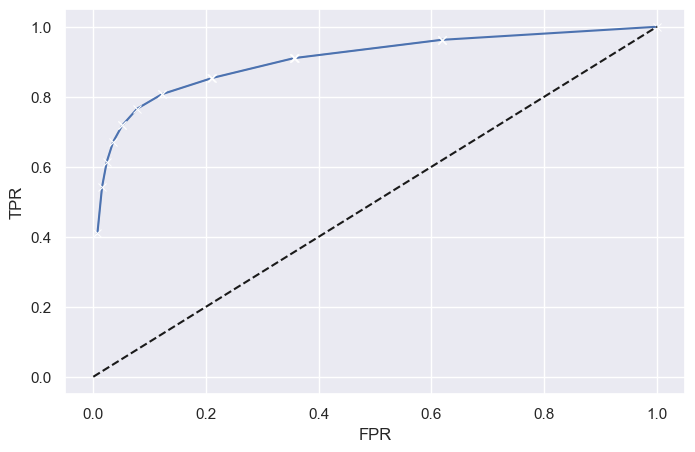

time: 1.05 s (started: 2022-12-18 18:15:10 -06:00)


In [16]:
# PR & ROC Curve
thresholds = (np.arange(0,101,1)/100).tolist()
roc_scores = []
for threshold in tqdm(thresholds):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    df_test['tp'] = (df_test['predicted'] >= threshold) & (df_test['actual'] ==1)
    df_test['fp'] = (df_test['predicted'] >= threshold) & (df_test['actual'] ==0)
    df_test['fn'] = (df_test['predicted'] < threshold)  & (df_test['actual'] ==1)
    df_test['tn'] = (df_test['predicted'] < threshold)  & (df_test['actual'] ==0)
    tp = df_test['tp'].sum()
    fp = df_test['fp'].sum()
    fn = df_test['fn'].sum()
    tn = df_test['tn'].sum()
    # print(tp,fp,fn,tn)
    TPR = tp / (tp+fn)
    FPR = fp / (fp+tn)
    Precision = tp / (tp+fp)
    Recall = tp / (tp+fn)
    # print(TPR, FPR)
    roc_scores.append([TPR, FPR, Precision, Recall])

roc_curv_df = pd.DataFrame(roc_scores, columns = ["TPR", "FPR", "Precision", "Recall"])
roc_curv_df["thresholds"] = thresholds
sns.set(rc={"figure.figsize":(8, 5)}) 
ax1 = sns.lineplot(roc_curv_df.Precision,roc_curv_df.Recall, marker = "x", markerfacecolor='blue')
plt.show();

ax2 = sns.lineplot(roc_curv_df.FPR,roc_curv_df.TPR, marker = "x", markerfacecolor = 'r')
plt.plot([0,1],[0,1],"k--")
plt.show();


In [17]:
from sklearn.metrics import average_precision_score, precision_recall_curve, auc
from sklearn.metrics import roc_auc_score
rf_roc_auc = roc_auc_score(y_test, y_pred_prob)
rf_roc_auc

# Data to plot precision - recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)

0.8736244386993572
time: 0 ns (started: 2022-12-18 18:15:11 -06:00)


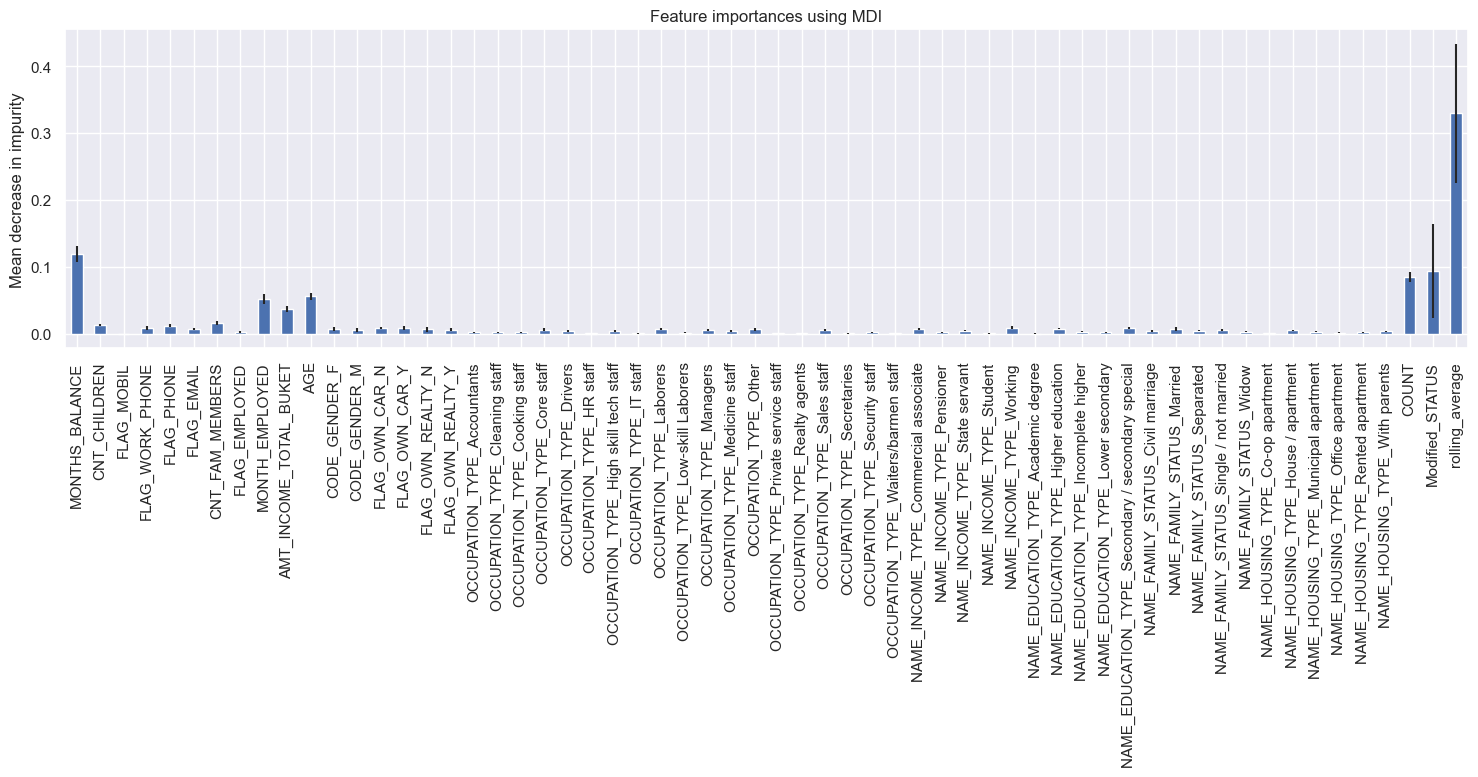

time: 2.53 s (started: 2022-12-18 18:15:11 -06:00)


In [18]:
# 2) Feature Important
importances = rf_model.feature_importances_
plt.rcParams.update({'figure.figsize': (15.0,8.0)})
plt.rcParams.update({'font.size': 14})
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
forest_importances = pd.Series(importances, index=x_train.columns)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [19]:
# Selected Features:
l2 = x_train.columns
l1 = range(0,65)
columns_list_index = dict(zip(l1,l2))
selected_features = [59,0,58,57,10,8,9,6,1]
selected_features_list = []
for i in selected_features:
    selected_features = x_train.columns[i]
    # selected_features_list = selected_features_list.append(selected_features)  # Why Does not work?
    print("Feature Number {}:".format(i),"\t", selected_features) 

Feature Number 59: 	 rolling_average
Feature Number 0: 	 MONTHS_BALANCE
Feature Number 58: 	 Modified_STATUS
Feature Number 57: 	 COUNT
Feature Number 10: 	 AGE
Feature Number 8: 	 MONTH_EMPLOYED
Feature Number 9: 	 AMT_INCOME_TOTAL_BUKET
Feature Number 6: 	 CNT_FAM_MEMBERS
Feature Number 1: 	 CNT_CHILDREN
time: 0 ns (started: 2022-12-18 18:15:14 -06:00)


#### Grid Search Cross Validation

In [20]:
from sklearn.model_selection import GridSearchCV
param_grid = {"n_estimators": np.arange(1,30)}

time: 15 ms (started: 2022-12-18 18:15:14 -06:00)


In [21]:
rf = RandomForestClassifier()
rf_cv = GridSearchCV(rf,param_grid, cv = 10)
rf_cv.fit(x_train,y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])})

time: 1min 24s (started: 2022-12-18 18:15:14 -06:00)


In [22]:
print(rf_cv.best_params_)
print(rf_cv.best_score_)

{'n_estimators': 21}
0.8701065619742009
time: 0 ns (started: 2022-12-18 18:16:38 -06:00)


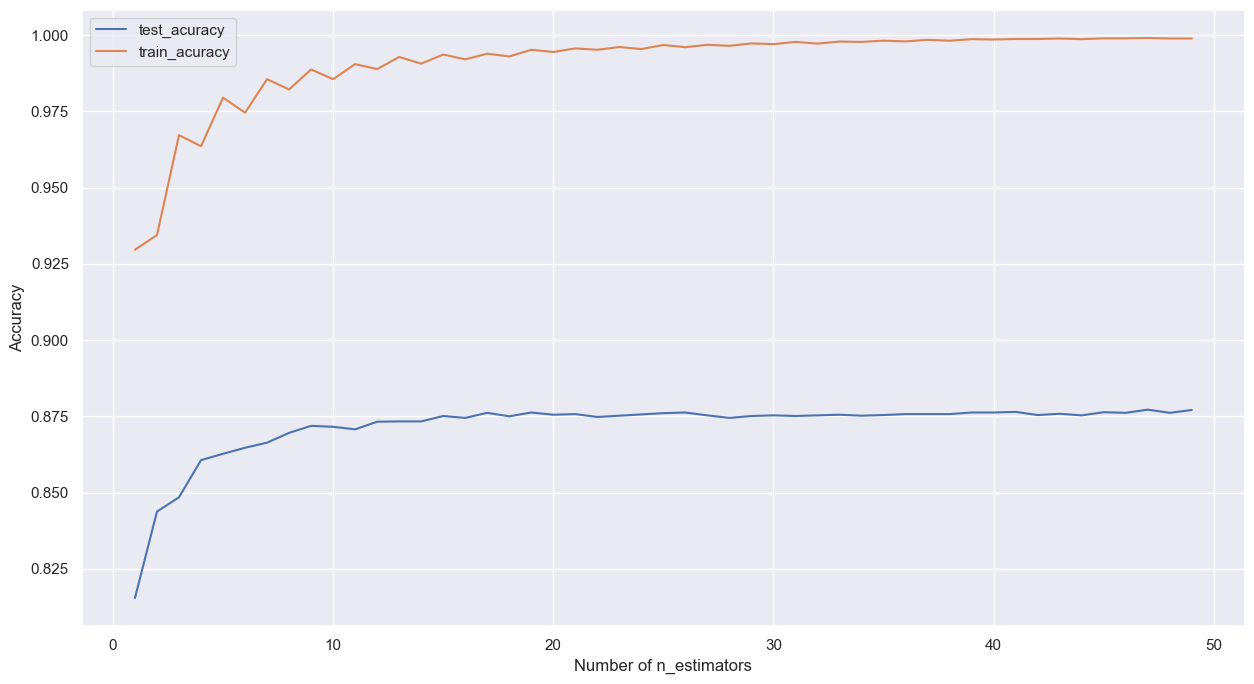

time: 32 s (started: 2022-12-18 18:16:38 -06:00)


In [23]:
# As another aproach, I develop a for loop to apply a range of values for n_estimators to find out with is the most appropriate one for our model?
n_estimators = np.arange(1,50)
test_acuracy = np.empty(len(n_estimators))
train_acuracy = np.empty(len(n_estimators))


for i, k in enumerate(n_estimators):
    rf_model = RandomForestClassifier(n_estimators=k, random_state = 42, verbose=0)     #What is better than verbose? it make the notebook too busy.
    rf_model.fit(x_train, y_train)
    test_acuracy[i]  = rf_model.score(x_test , y_test)
    train_acuracy[i] = rf_model.score(x_train, y_train)

plt.plot(n_estimators,test_acuracy, label = "test_acuracy")
plt.plot(n_estimators,train_acuracy, label = "train_acuracy")
plt.legend()
plt.xlabel('Number of n_estimators')
plt.ylabel("Accuracy")
plt.show()

### Re-Develop the Random Forest Model with selected features and n_estimators

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score 

y = data.loc[:,'3M_LABEL'].astype(float)
x= data[["rolling_average","MONTHS_BALANCE","Modified_STATUS","COUNT","AGE","MONTH_EMPLOYED","AMT_INCOME_TOTAL_BUKET"]]     # 'COUNT',    /

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.35, random_state = 42)   # Should i go for stratify = lable? NO! https://www.scribbr.com/methodology/stratified-sampling/

rf_model_fin = RandomForestClassifier(n_estimators = 25, random_state = 42, verbose=0) 
rf_model_fin.fit(x_train, y_train)
y_pred_prob_fin = rf_model_fin.predict_proba(x_test)
y_predict_fin = rf_model_fin.predict(x_test)
print('rf_model_accuracy_score:', accuracy_score(y_test, y_predict_fin))
print('precision_score:'        , precision_score(y_test, y_predict_fin))
print('rf_model_recall_score:'  , recall_score(y_test, y_predict_fin))
print('rf_model_roc_auc_score:' , roc_auc_score(y_test, y_predict_fin))
print('rf_model_f1_score:'      , f1_score(y_test, y_predict_fin))


rf_model_accuracy_score: 0.8640908144136639
precision_score: 0.8885714285714286
rf_model_recall_score: 0.6784044873792459
rf_model_roc_auc_score: 0.8178507655103643
rf_model_f1_score: 0.7693938858455557
time: 563 ms (started: 2022-12-18 18:17:10 -06:00)


# Evaluation

In [25]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix     (y_test , y_predict)
cr = classification_report(y_test , y_predict)

print(cm)
print(cr)

[[6064  329]
 [ 904 2305]]
              precision    recall  f1-score   support

         0.0       0.87      0.95      0.91      6393
         1.0       0.88      0.72      0.79      3209

    accuracy                           0.87      9602
   macro avg       0.87      0.83      0.85      9602
weighted avg       0.87      0.87      0.87      9602

time: 31 ms (started: 2022-12-18 18:17:11 -06:00)


#### Roc Curve

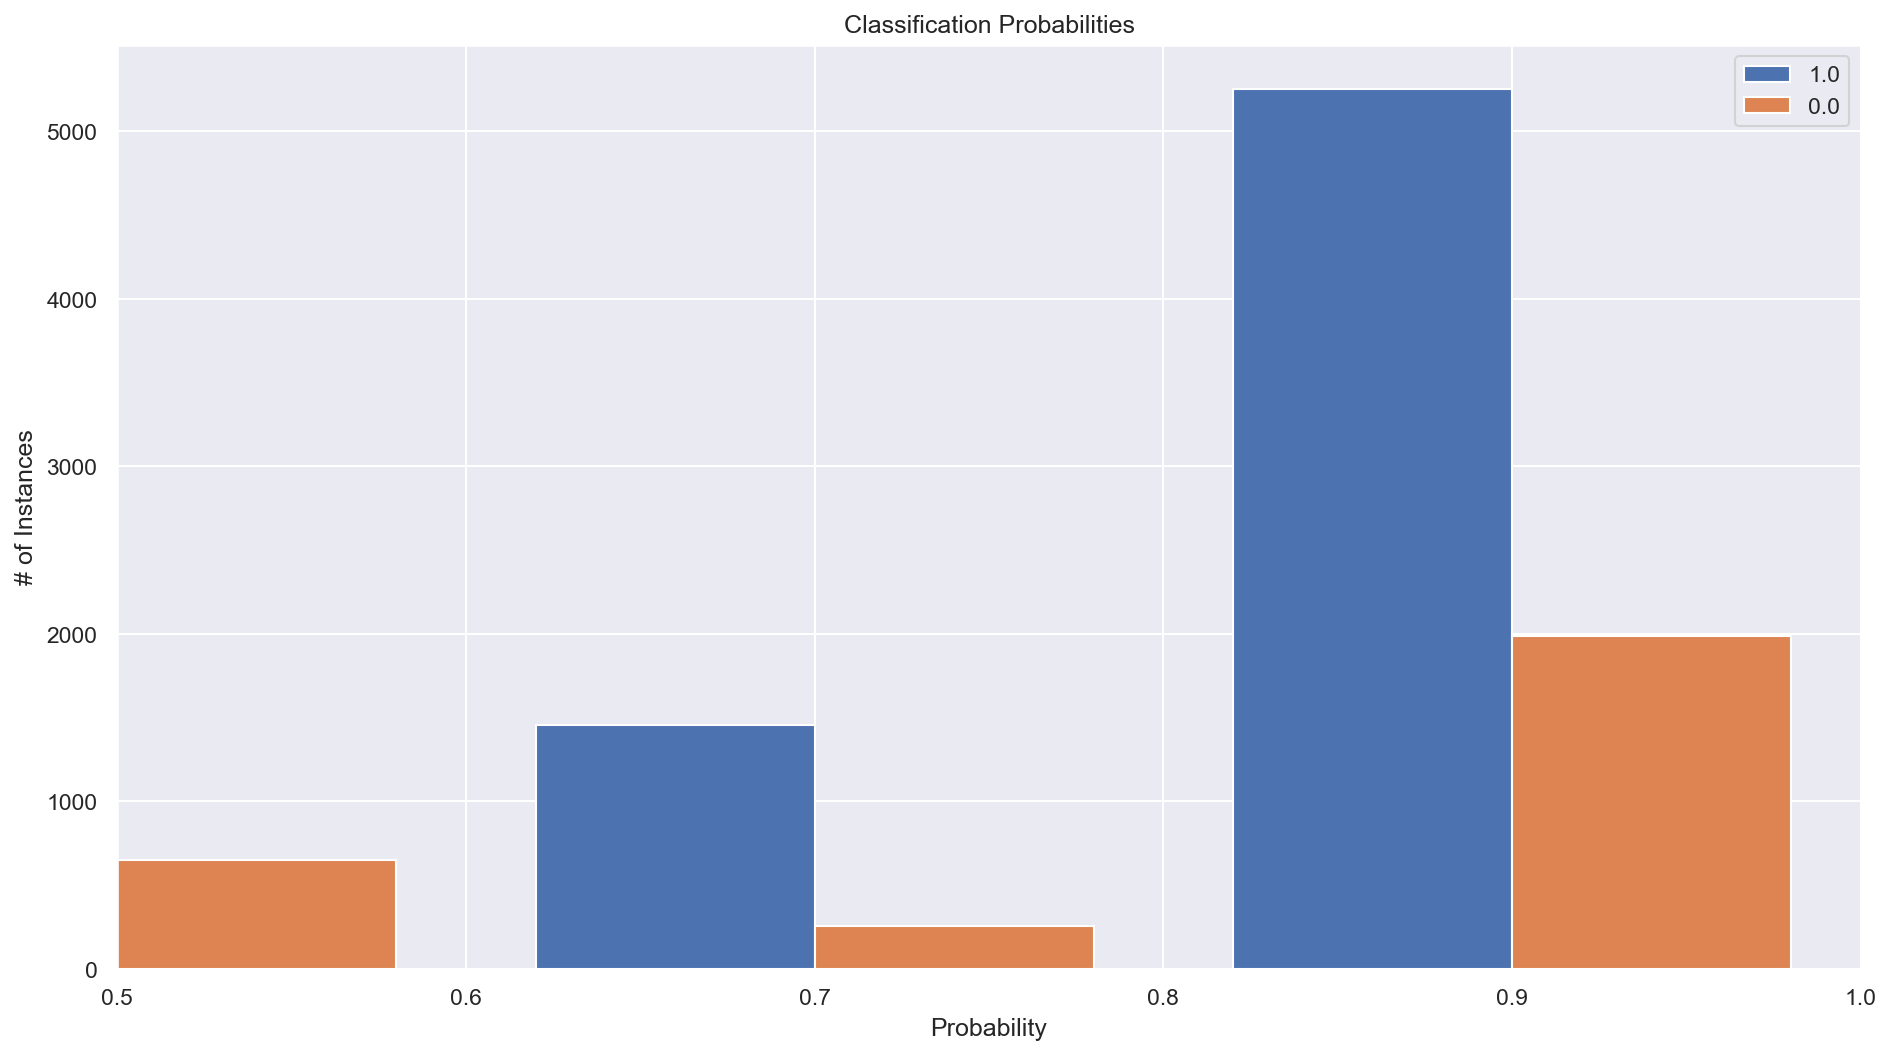

time: 250 ms (started: 2022-12-18 18:17:11 -06:00)


In [26]:
# get the probability distribution
probas = rf_model_fin.predict_proba(x_test)
# plot
plt.figure(dpi=150)
plt.hist(probas, bins=5)
plt.title('Classification Probabilities')
plt.xlabel('Probability')
plt.ylabel('# of Instances')
plt.xlim([0.5, 1.0])
plt.legend(y.unique())
plt.show()

In [27]:
y_test.value_counts(dropna = False)

0.0    6393
1.0    3209
Name: 3M_LABEL, dtype: int64

time: 0 ns (started: 2022-12-18 18:17:11 -06:00)


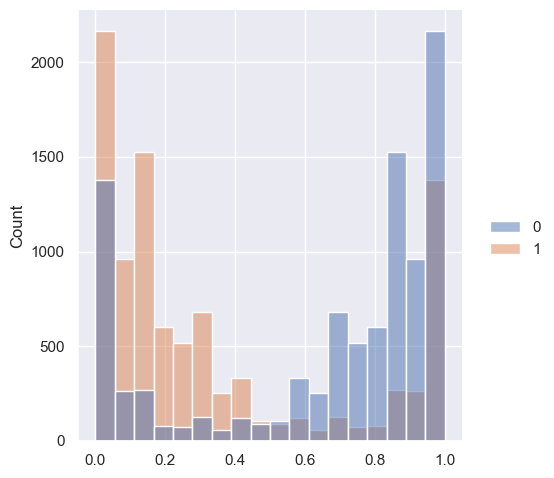

time: 360 ms (started: 2022-12-18 18:17:11 -06:00)


In [28]:
import seaborn as sns
probas = rf_model_fin.predict_proba(x_test)
sns.displot(probas)

In [29]:
from sklearn.metrics import roc_curve, auc
y_pred_prob = rf_model_fin.predict_proba(x_test)[:,1]
t = pd.DataFrame(y_pred_prob, columns= ['value'])

# t.value.value_counts()
t.shape

(9602, 1)

time: 47 ms (started: 2022-12-18 18:17:12 -06:00)


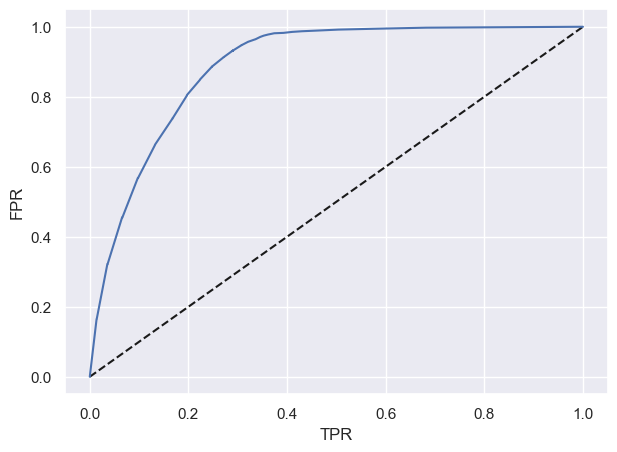

time: 203 ms (started: 2022-12-18 18:17:12 -06:00)


In [30]:
# Create ROC curve based on the built in function.
plt.rcParams.update({'figure.figsize': (7.0,5.0)})
plt.rcParams.update({'font.size': 14})
y_pred_prob = rf_model_fin.predict_proba(x_test)
fpr, tpr, thresholdss = roc_curve(y_test, y_pred_prob[:,0], pos_label=0)
plt.plot([0,1],[0,1],"k--")
plt.plot(fpr,tpr)

plt.xlabel('TPR')
plt.ylabel('FPR')
plt.show();




In [31]:
from sklearn.metrics import roc_auc_score
rf_roc_auc = roc_auc_score(y_test, y_pred_prob[:,1])
rf_roc_auc


0.8881832960706039

time: 0 ns (started: 2022-12-18 18:17:12 -06:00)


In [32]:
y_test.value_counts(dropna = False)

0.0    6393
1.0    3209
Name: 3M_LABEL, dtype: int64

time: 16 ms (started: 2022-12-18 18:17:12 -06:00)


In [33]:
# How to import picture into my notebook?

from IPython.display import Image
Image(url="Confusion Matrix Interpretation.png", width=400, height=400)

time: 0 ns (started: 2022-12-18 18:17:12 -06:00)


#### ROC CURVE CALCULATION Manually

In [34]:
y_pred_prob_fin = rf_model_fin.predict_proba(x_test)[:,1]     # Question: x or x_test?
df = pd.DataFrame({"predicted":y_pred_prob_fin})
df['actual'] = y_test.values


time: 109 ms (started: 2022-12-18 18:17:12 -06:00)


100%|██████████| 101/101 [00:00<00:00, 644.41it/s]


0.887762996659491

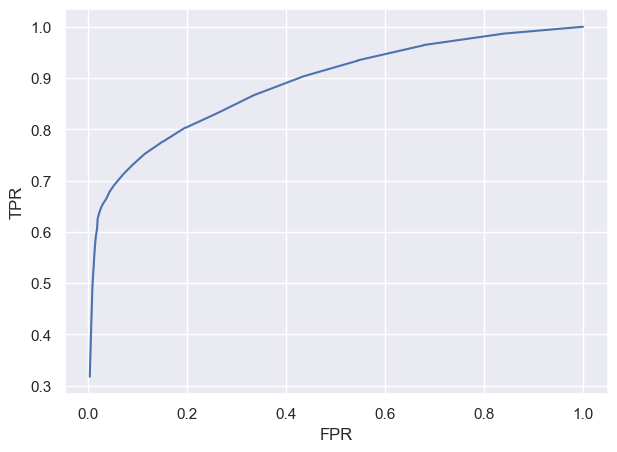

time: 703 ms (started: 2022-12-18 18:17:13 -06:00)


In [35]:
thresholds = (np.arange(0,101,1)/100).tolist()
roc_scores = []
for threshold in tqdm(thresholds):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    df['tp'] = (df['predicted'] >= threshold) & (df['actual'] ==1)
    df['fp'] = (df['predicted'] >= threshold) & (df['actual'] ==0)
    df['fn'] = (df['predicted'] < threshold) & (df['actual'] ==1)
    df['tn'] = (df['predicted'] < threshold) & (df['actual'] ==0)
    tp = df['tp'].sum()
    fp = df['fp'].sum()
    fn = df['fn'].sum()
    tn = df['tn'].sum()
    # print(tp,fp,fn,tn)
    TPR = tp / (tp+fn)
    FPR = fp / (fp+tn)
    # print(TPR, FPR)
    roc_scores.append([TPR, FPR])

roc_curv_df = pd.DataFrame(roc_scores, columns = ["TPR", "FPR"])
roc_curv_df["thresholds"] = thresholds
sns.lineplot(roc_curv_df.FPR,roc_curv_df.TPR)
# plt.plot(X_plot, Y_plot, color='r')
# plt.xlabel("FPR")
# plt.ylabel("TPR")

#AUC_ROC
from numpy import trapz
abs(np.trapz(roc_curv_df.TPR,roc_curv_df.FPR))

In [36]:
# Save the Metrics in a dataframe for future comparison:
y_predict_fin = rf_model_fin.predict(x_test)
rf_model_accuracy_score = accuracy_score(y_test, y_predict_fin)
rf_precision_score        =    precision_score(y_test, y_predict_fin)
rf_model_recall_score  =    recall_score(y_test, y_predict_fin)
rf_model_roc_auc_score =    roc_auc_score(y_test, y_predict_fin)
rf_model_f1_score      =    f1_score(y_test, y_predict_fin)
list_of_rows = []
s = pd.Series({'Model': 'RandomForest_Final'
               ,'accuracy_score': rf_model_accuracy_score
               ,'precision_score':      rf_precision_score           
               ,'recall_score':   rf_model_recall_score  
               ,'roc_auc_score':  rf_model_roc_auc_score 
               ,'f1_score':       rf_model_f1_score })
list_of_rows.append(s)
saved_results = pd.DataFrame(list_of_rows)
saved_results

,Model,accuracy_score,precision_score,recall_score,roc_auc_score,f1_score
0,RandomForest_Final,0.864091,0.888571,0.678404,0.817851,0.769394


time: 78 ms (started: 2022-12-18 18:17:13 -06:00)


In [37]:
import winsound
frequency = 2000  # Set Frequency To 2500 Hertz
duration = 1000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

time: 1.01 s (started: 2022-12-18 18:17:13 -06:00)


# XGBOOST Model

In [38]:
import pandas as pd
import numpy as np
import xgboost
import catboost
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt

time: 109 ms (started: 2022-12-18 18:17:15 -06:00)


In [39]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.35, random_state = 42)
xgboost_simple = xgboost.XGBClassifier( verbosity = 0)
eval_set = [(x_test, y_test)]

xgb = xgboost_simple.fit(x_train,y_train, early_stopping_rounds = 10, eval_set = eval_set, verbose = 0)

time: 297 ms (started: 2022-12-18 18:17:15 -06:00)


In [40]:
from sklearn.metrics import accuracy_score, recall_score ,roc_auc_score , f1_score    
xgb_predict = xgb.predict(x_test)

xgb_model_accuracy_score = accuracy_score(y_test, xgb_predict)
xgb_precision_score      = precision_score(y_test, xgb_predict)
xgb_model_recall_score   =  recall_score(y_test, xgb_predict)
xgb_model_roc_auc_score  =  roc_auc_score(y_test, xgb_predict)
xgb_model_f1_score       =  f1_score(y_test, xgb_predict)


print('xgb_model_accuracy_score:', accuracy_score(y_test, xgb_predict))
print('xgb_precision_score:', precision_score(y_test, xgb_predict))
print('xgb_model_recall_score:', recall_score(y_test, xgb_predict))
print('xgb_model_roc_auc_score:', roc_auc_score(y_test, xgb_predict))
print('xgb_model_f1_score:', f1_score(y_test, xgb_predict))

xgb_model_accuracy_score: 0.8632576546552801
xgb_precision_score: 0.9397031539888683
xgb_model_recall_score: 0.6313493300093487
xgb_model_roc_auc_score: 0.8055072944431226
xgb_model_f1_score: 0.7552656104380242
time: 78 ms (started: 2022-12-18 18:17:15 -06:00)


In [41]:
#Roc Curve
from sklearn.metrics import roc_curve
y_pred_ptob = xgboost_simple.predict_proba(x_test)

time: 0 ns (started: 2022-12-18 18:17:15 -06:00)


<AxesSubplot:ylabel='Density'>

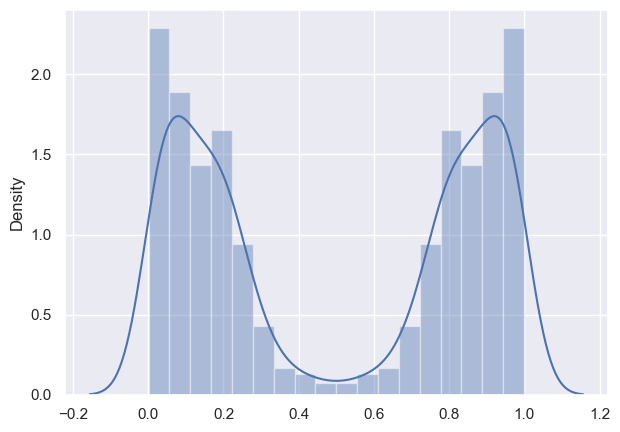

time: 218 ms (started: 2022-12-18 18:17:15 -06:00)


In [42]:
sns.distplot(y_pred_ptob)

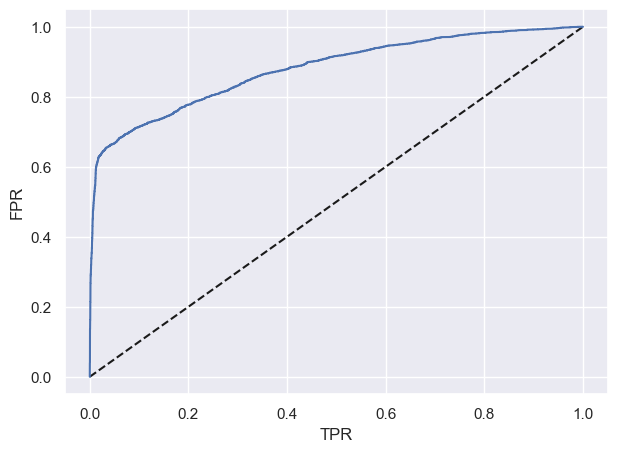

time: 187 ms (started: 2022-12-18 18:17:16 -06:00)


In [43]:
y_pred_prob = xgboost_simple.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0,1],[0,1],"k--")
plt.plot(fpr,tpr)

plt.xlabel('TPR')
plt.ylabel('FPR')
plt.show();

In [44]:
# XGBOOST MODEL VALIDATION
y_train_pred  = xgboost_simple.predict_proba(x_train)[:,1]  # why we should get the second value?
y_test_pred   = xgboost_simple.predict_proba(x_test)[:,1]
AUC_XGB_train = roc_auc_score(y_train, y_train_pred)
AUC_XGB_test  = roc_auc_score(y_test, y_test_pred)

print("AUC XGB TRAIN: {:.4f}\nAUC XGB TEST: {:.4f}".format(roc_auc_score(y_train, y_train_pred), roc_auc_score(y_test, y_test_pred)))

AUC XGB TRAIN: 0.9156
AUC XGB TEST: 0.8790
time: 63 ms (started: 2022-12-18 18:17:16 -06:00)


#### Hyperparameter Tuning

In [45]:
learning_rate_list = [0.02,0.05]#,0.1]
max_depth_list = [2,3,5] 
n_estimator_list =[1000,2000]#,3000]


params_dict = {
                "learning_rate_list":learning_rate_list,
                "max_depth_list":max_depth_list,
                "n_estimator_list":n_estimator_list,}
                # "subsample_list":subsample_list,
                # "colsample_bytree_list":colsample_bytree_list}

num_combination = 1
for v in params_dict.values():
    print(len(v))
    num_combination *= len(v)

print(num_combination)
params_dict

2
3
2
12


{'learning_rate_list': [0.02, 0.05],
 'max_depth_list': [2, 3, 5],
 'n_estimator_list': [1000, 2000]}

time: 0 ns (started: 2022-12-18 18:17:16 -06:00)


In [46]:
model_xgboost_hp = GridSearchCV(estimator = xgboost.XGBClassifier(subsample = 0.5, 
                                                                    colsample_bytree = 0.25, 
                                                                    eval_metric='auc', 
                                                                    use_label_encoder = False),
                                                param_grid = params_dict, 
                                                cv = 2,
                                                # scoring = my_roc_auc_score, 
                                                return_train_score = True, 
                                                verbose = 4)

model_xgboost_hp.fit(x,y)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV 1/2] END learning_rate_list=0.02, max_depth_list=2, n_estimator_list=1000;, score=(train=0.862, test=0.863) total time=   0.3s
[CV 2/2] END learning_rate_list=0.02, max_depth_list=2, n_estimator_list=1000;, score=(train=0.863, test=0.860) total time=   0.3s
[CV 1/2] END learning_rate_list=0.02, max_depth_list=2, n_estimator_list=2000;, score=(train=0.862, test=0.863) total time=   0.3s
[CV 2/2] END learning_rate_list=0.02, max_depth_list=2, n_estimator_list=2000;, score=(train=0.863, test=0.860) total time=   0.3s
[CV 1/2] END learning_rate_list=0.02, max_depth_list=3, n_estimator_list=1000;, score=(train=0.862, test=0.863) total time=   0.3s
[CV 2/2] END learning_rate_list=0.02, max_depth_list=3, n_estimator_list=1000;, score=(train=0.863, test=0.860) total time=   0.3s
[CV 1/2] END learning_rate_list=0.02, max_depth_list=3, n_estimator_list=2000;, score=(train=0.862, test=0.863) total time=   0.3s
[CV 2/2] END learning_

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.25,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', gamma=None, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_c...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             param_grid={'learning_rate_list': [0.02, 0.05],
                         'max_depth_list': [2, 3, 5],
                         'n_estimator_list': [1000, 2000]},
             return_train_score=True, verbose=4)

time: 11.2 s (started: 2022-12-18 18:17:16 -06:00)


In [47]:
df_cv_results = pd.DataFrame(model_xgboost_hp.cv_results_)
df_cv_results = df_cv_results[['rank_test_score', 'mean_train_score','mean_test_score','param_max_depth_list', 'param_n_estimator_list', 'params']]
df_cv_results.sort_values(by = ['rank_test_score'], inplace  = True)
df_cv_results

,rank_test_score,mean_train_score,mean_test_score,param_max_depth_list,param_n_estimator_list,params
0,1,0.862533,0.86133,2,1000,"{'learning_rate_list': 0.02, 'max_depth_list':..."
1,1,0.862533,0.86133,2,2000,"{'learning_rate_list': 0.02, 'max_depth_list':..."
2,1,0.862533,0.86133,3,1000,"{'learning_rate_list': 0.02, 'max_depth_list':..."
3,1,0.862533,0.86133,3,2000,"{'learning_rate_list': 0.02, 'max_depth_list':..."
4,1,0.862533,0.86133,5,1000,"{'learning_rate_list': 0.02, 'max_depth_list':..."
5,1,0.862533,0.86133,5,2000,"{'learning_rate_list': 0.02, 'max_depth_list':..."
6,1,0.862533,0.86133,2,1000,"{'learning_rate_list': 0.05, 'max_depth_list':..."
7,1,0.862533,0.86133,2,2000,"{'learning_rate_list': 0.05, 'max_depth_list':..."
8,1,0.862533,0.86133,3,1000,"{'learning_rate_list': 0.05, 'max_depth_list':..."
9,1,0.862533,0.86133,3,2000,"{'learning_rate_list': 0.05, 'max_depth_list':..."


time: 16 ms (started: 2022-12-18 18:17:27 -06:00)


Final Model

In [48]:
xgboost_model_fin = xgboost.XGBClassifier(learning_rate = 0.05,
                                     max_depth = 2,
                                     n_estimator = 1000,
                                     subsample = 0.5,
                                     colsample_bytree = 0.25,
                                     eval_metric = 'auc',
                                     verbosity = 1
                                     ,use_label_encoder = False)

time: 0 ns (started: 2022-12-18 18:17:27 -06:00)


In [49]:
eval_set = [(x_train, y_train),(x_test,y_test)]

xgboost_model_fin.fit(x_train,y_train, early_stopping_rounds=20, eval_set = eval_set, verbose = True)

[18:17:27] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.50461	validation_1-auc:0.50481
[1]	validation_0-auc:0.52754	validation_1-auc:0.53495
[2]	validation_0-auc:0.53795	validation_1-auc:0.54930
[3]	validation_0-auc:0.53859	validation_1-auc:0.54925
[4]	validation_0-auc:0.59194	validation_1-auc:0.59406
[5]	validation_0-auc:0.74997	validation_1-auc:0.74959
[6]	validation_0-auc:0.75715	validation_1-auc:0.75457
[7]	validation_0-auc:0.75743	validation_1-auc:0.75475
[8]	validation_0-auc:0.75865	validation_1-auc:0.75591
[9]	validation_0-auc:0.85171	validation_1-auc:0.85232
[10]	validation_0-auc:0.85295	validation

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.25,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimator=1000,
              n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, ...)

time: 360 ms (started: 2022-12-18 18:17:27 -06:00)


In [50]:
# XGBOOST MODEL VALIDATION
y_train_pred  = xgboost_model_fin.predict_proba(x_train)[:,1]  # why we should get the second value?
y_test_pred   = xgboost_model_fin.predict_proba(x_test)[:,1]
AUC_train = roc_auc_score(y_train, y_train_pred)
AUC_test  = roc_auc_score(y_test, y_test_pred)

time: 31 ms (started: 2022-12-18 18:17:28 -06:00)


In [51]:
print(AUC_train)
print(AUC_test)

0.8530283125338853
0.8529566729191231
time: 0 ns (started: 2022-12-18 18:17:28 -06:00)


In [52]:
print("AUC TRAIN: {:.4f}\nAUC TEST: {:.4f}".format(roc_auc_score(y_train, y_train_pred), roc_auc_score(y_test, y_test_pred)))

AUC TRAIN: 0.8530
AUC TEST: 0.8530
time: 15 ms (started: 2022-12-18 18:17:28 -06:00)


In [53]:
saved_results

,Model,accuracy_score,precision_score,recall_score,roc_auc_score,f1_score
0,RandomForest_Final,0.864091,0.888571,0.678404,0.817851,0.769394


time: 0 ns (started: 2022-12-18 18:17:28 -06:00)


In [54]:
# Save the xgboost_model_fin metrics in a dataframe for future comparison:
xgb_predict_fin = xgboost_model_fin.predict(x_test)

xgb_model_accuracy_score =  accuracy_score(y_test, xgb_predict_fin)
xgb_precision_score      =  precision_score(y_test, xgb_predict_fin)
xgb_model_recall_score   =  recall_score(y_test, xgb_predict_fin)
xgb_model_roc_auc_score  =  roc_auc_score(y_test, xgb_predict_fin)
xgb_model_f1_score       =  f1_score(y_test, xgb_predict_fin)


print("xgb_model_accuracy_score" ,  accuracy_score(y_test, xgb_predict_fin))
print("xgb_precision_score"      ,  precision_score(y_test, xgb_predict_fin))
print("xgb_model_recall_score"   ,  recall_score(y_test, xgb_predict_fin))
print("xgb_model_roc_auc_score"  ,  roc_auc_score(y_test, xgb_predict_fin))
print("xgb_model_f1_score"       ,  f1_score(y_test, xgb_predict_fin))

s2 = pd.Series({'Model': 'xgboost_model_fin'
               ,"accuracy_score":xgb_model_accuracy_score
               ,"precision_score"     :xgb_precision_score
               ,"recall_score"  :xgb_model_recall_score
               ,"roc_auc_score" :xgb_model_roc_auc_score
               ,"f1_score"      :xgb_model_f1_score})
# list_of_rows.append(s)
# saved_results = pd.DataFrame(list_of_rows)
saved_results = saved_results.append(s2, ignore_index=True)
saved_results

xgb_model_accuracy_score 0.7810872734846906
xgb_precision_score 0.9525756336876533
xgb_model_recall_score 0.36304144593331256
xgb_model_roc_auc_score 0.6769845114853486
xgb_model_f1_score 0.5257220216606497


,Model,accuracy_score,precision_score,recall_score,roc_auc_score,f1_score
0,RandomForest_Final,0.864091,0.888571,0.678404,0.817851,0.769394
1,xgboost_model_fin,0.781087,0.952576,0.363041,0.676985,0.525722


time: 79 ms (started: 2022-12-18 18:17:28 -06:00)


# CATBOOST

In [55]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt

time: 16 ms (started: 2022-12-18 18:17:28 -06:00)


In [56]:
# Reload the Cleaned Data
data = pd.read_csv(r'C:\Users\shaha\OneDrive\Documents\credit_score\Final_Data.csv')
data.shape

(687454, 64)

time: 2.28 s (started: 2022-12-18 18:17:28 -06:00)


In [57]:
# Removing the rows that have null value  in 3 month lag. 
data = data.dropna(subset = ['3M_LABEL']).reset_index(drop=True)
data.shape

(617197, 64)

time: 297 ms (started: 2022-12-18 18:17:31 -06:00)


0.0    18288
1.0     9144
Name: 3M_LABEL, dtype: int64

0.0    0.666667
1.0    0.333333
Name: 3M_LABEL, dtype: float64

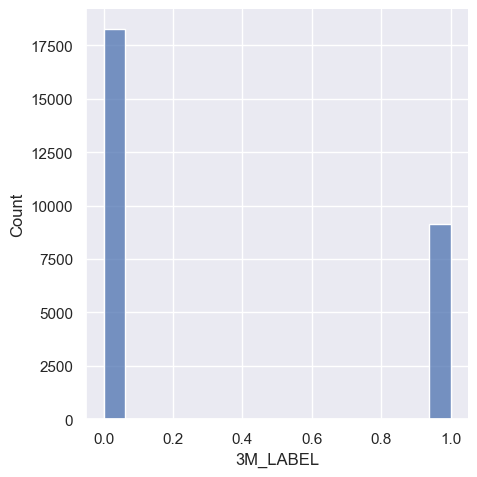

time: 531 ms (started: 2022-12-18 18:17:31 -06:00)


In [58]:
# Under-sampling Techniques to Handle Imbalanced Data
data_0 = data.loc[data['3M_LABEL']==0,:].sample(2*len(data.loc[data['3M_LABEL']==1,:]))
data_1 = data.loc[data['3M_LABEL']==1,:]
data = pd.concat([data_0,data_1] ).sample(frac = 1).sample(frac = 1).sample(frac = 1).reset_index(drop = True)

display(data['3M_LABEL'].value_counts(normalize=False),data['3M_LABEL'].value_counts(normalize=True))

sns.displot(data['3M_LABEL'], kde = False)
plt.show();

In [59]:
# Use numpy to convert to arrays
import numpy as np
# Labels are the values we want to predict
y = data.loc[:,'3M_LABEL'].astype(float) #or"float64"
# Remove the labels from the features
# axis 1 refers to the columns

x = data.iloc[:,1:]
x = data.drop(['ID','3M_LABEL','BINARY_STATUS'], axis = 1) # , 'COUNT',    /
# Saving feature names for later use
feature_list = list(x.columns)
# should be carefull for float values. we need decimals if we have.


time: 15 ms (started: 2022-12-18 18:17:32 -06:00)


In [60]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 42)   # Should i go for stratify = lable? NO! https://www.scribbr.com/methodology/stratified-sampling/

time: 16 ms (started: 2022-12-18 18:17:32 -06:00)


In [61]:
cat_feature = ['STATUS']

time: 0 ns (started: 2022-12-18 18:17:32 -06:00)


In [62]:
model_cb = CatBoostClassifier(iterations = 100, random_state=42, eval_metric = 'AUC')#['F1'])#,'Logloss','F1'])'AUC'

time: 0 ns (started: 2022-12-18 18:17:32 -06:00)


In [63]:
cat_feature = ['STATUS']
CatBoost_model = model_cb.fit(x_train, y_train, plot = True,cat_features=cat_feature, eval_set = (x_test, y_test),verbose = 0) #cat_features=cat_feature
CatBoost_model

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

time: 5 s (started: 2022-12-18 18:17:32 -06:00)


In [64]:
CatBoost_model_y_pred = CatBoost_model.predict(x_test)

time: 16 ms (started: 2022-12-18 18:17:37 -06:00)


In [65]:
from sklearn.metrics import f1_score, accuracy_score
f1_score(y_test, CatBoost_model_y_pred)
accuracy_score(y_test, CatBoost_model_y_pred)

0.8671624380285797

time: 15 ms (started: 2022-12-18 18:17:37 -06:00)


<function auc at 0x000002045B767760>


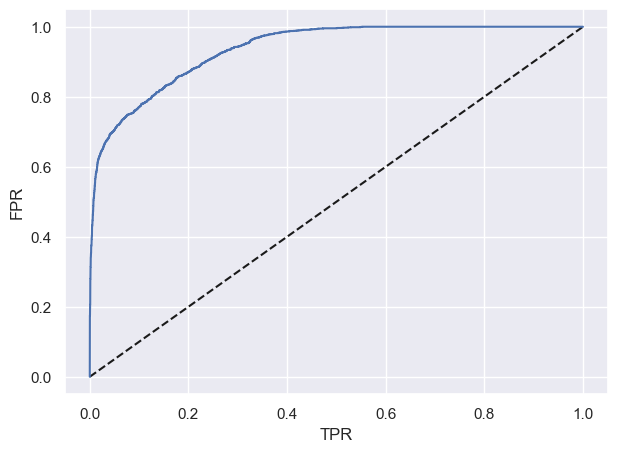

time: 156 ms (started: 2022-12-18 18:17:37 -06:00)


In [66]:
from sklearn.metrics import auc, roc_curve
print(auc)
y_pred_prob = CatBoost_model.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0,1],[0,1],"k--")
plt.plot(fpr,tpr)

plt.xlabel('TPR')
plt.ylabel('FPR')
plt.show();

AUC for CatBoost

In [67]:
y_train_pred = CatBoost_model.predict_proba(x_train)[:,1]
y_test_pred  = CatBoost_model.predict_proba(x_test)[:,1]

AUC_train = roc_auc_score(y_train, y_train_pred)
AUC_test  = roc_auc_score(y_test, y_test_pred)

print('AUC_train:{:.4f} and AUC_test:{:.4f}'.format(AUC_train, AUC_test))

AUC_train:0.9566 and AUC_test:0.9369
time: 47 ms (started: 2022-12-18 18:17:37 -06:00)


# ROC CURVE CALCULATION

In [68]:
y_pred_prob = CatBoost_model.predict_proba(x_test)[:,1]

time: 16 ms (started: 2022-12-18 18:17:37 -06:00)


In [69]:
# y_pred_prob
df = pd.DataFrame(y_pred_prob, columns = ['predicted'])
df['actual'] = y_test.values
# df.to_csv(r'C:\Users\shaha\OneDrive\Documents\credit_score\test.csv')

time: 0 ns (started: 2022-12-18 18:17:38 -06:00)


In [70]:
df

,predicted,actual
0,0.040777,0.0
1,0.000592,0.0
2,0.000413,0.0
3,0.098483,0.0
4,0.993370,1.0
...,...,...
6853,0.172332,1.0
6854,0.317331,1.0
6855,0.147032,0.0
6856,0.309026,1.0


time: 0 ns (started: 2022-12-18 18:17:38 -06:00)


100%|██████████| 105/105 [00:00<00:00, 538.69it/s]


<AxesSubplot:xlabel='FPR', ylabel='TPR'>

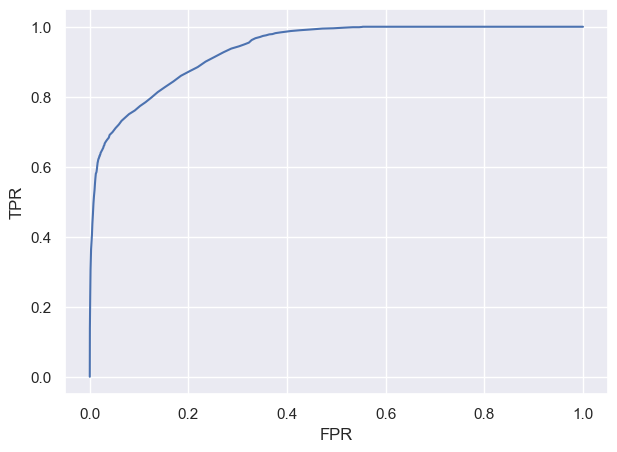

time: 500 ms (started: 2022-12-18 18:17:38 -06:00)


In [71]:
thresholds = (np.arange(0,105,1)/100).tolist()
roc_scores = []
for threshold in tqdm(thresholds):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    df['tp'] = (df['predicted'] >= threshold) & (df['actual'] ==1)
    df['fp'] = (df['predicted'] >= threshold) & (df['actual'] ==0)
    df['fn'] = (df['predicted'] < threshold) & (df['actual'] ==1)
    df['tn'] = (df['predicted'] < threshold) & (df['actual'] ==0)
    tp = df['tp'].sum()
    fp = df['fp'].sum()
    fn = df['fn'].sum()
    tn = df['tn'].sum()
    # print(tp,fp,fn,tn)
    TPR = tp / (tp+fn)
    FPR = fp / (fp+tn)
    # print(TPR, FPR)
    roc_scores.append([TPR, FPR])

roc_curv_df = pd.DataFrame(roc_scores, columns = ["TPR", "FPR"])
roc_curv_df["thresholds"] = thresholds
sns.lineplot(roc_curv_df.FPR,roc_curv_df.TPR)
# plt.plot(x_plot, y_plot, color='r')
# plt.xlabel("FPR")
# plt.ylabel("TPR")

In [72]:
from numpy import trapz
abs(np.trapz(roc_curv_df.TPR,roc_curv_df.FPR))

0.9368110303386306

time: 0 ns (started: 2022-12-18 18:17:38 -06:00)


In [73]:
# Save the xgboost_model_fin metrics in a dataframe for future comparison:
cb_predict_fin = CatBoost_model.predict(x_test)

cb_model_accuracy_score =  accuracy_score(y_test, cb_predict_fin)
cb_precision_score      =  precision_score(y_test, cb_predict_fin)
cb_model_recall_score   =  recall_score(y_test, cb_predict_fin)
cb_model_roc_auc_score  =  roc_auc_score(y_test, cb_predict_fin)
cb_model_f1_score       =  f1_score(y_test, cb_predict_fin)


print("cb_model_accuracy_score" ,  accuracy_score(y_test, cb_predict_fin))
print("cb_precision_score"      ,  precision_score(y_test, cb_predict_fin))
print("cb_model_recall_score"   ,  recall_score(y_test, cb_predict_fin))
print("cb_model_roc_auc_score"  ,  roc_auc_score(y_test, cb_predict_fin))
print("cb_model_f1_score"       ,  f1_score(y_test, cb_predict_fin))

s3 = pd.Series({'Model': 'cbboost_model_fin'
               ,"accuracy_score"      :cb_model_accuracy_score
               ,"precision_score"     :cb_precision_score
               ,"recall_score"  :cb_model_recall_score
               ,"roc_auc_score" :cb_model_roc_auc_score
               ,"f1_score"      :cb_model_f1_score})
# list_of_rows.append(s)
# saved_results = pd.DataFrame(list_of_rows)
saved_results = saved_results.append(s3, ignore_index=True)
saved_results

cb_model_accuracy_score 0.8671624380285797
cb_precision_score 0.921760391198044
cb_model_recall_score 0.6582278481012658
cb_model_roc_auc_score 0.8151003483992206
cb_model_f1_score 0.7680162974280621


,Model,accuracy_score,precision_score,recall_score,roc_auc_score,f1_score
0,RandomForest_Final,0.864091,0.888571,0.678404,0.817851,0.769394
1,xgboost_model_fin,0.781087,0.952576,0.363041,0.676985,0.525722
2,cbboost_model_fin,0.867162,0.921760,0.658228,0.815100,0.768016


time: 78 ms (started: 2022-12-18 18:17:38 -06:00)


In [74]:
# Save the selected Model in pickle format
import pickle
pickle.dump(CatBoost_model, open('credit_risk_CatBoost_model.pkl','wb'))

time: 16 ms (started: 2022-12-18 19:00:22 -06:00)


# END